In [1]:
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from os import listdir
import pymc as pm
from scipy.interpolate import interp1d
from constants import tDir

# from pymagglobal.utils import REARTH, nez2dif, dsh_basis, i2lm_l

from plot_functions import plot_DIF, plot_map
from data_handling import Data, adjust_declination
from adm import BaconAdm as AgeDepthModel

def get_lif_samps_and_mean(bs, depth=np.linspace(0, 100, 512)):
    beta = 2 / (bs[3] + bs[2] - bs[1] - bs[0])
    F_12 = beta[None, :] * (depth[:, None] - bs[0, None, :]) / (bs[1] - bs[0])[None, :]
    F_23 = beta[None, :]
    F_34 = beta[None, :] * (bs[3, None, :] - depth[:, None]) / (bs[3] - bs[2])[None, :]
    ind_12 = (bs[0, None, :] < depth[:, None]) * (depth[:, None] <= bs[1, None, :])
    ind_23 = (bs[1, None, :] < depth[:, None]) * (depth[:, None] <= bs[2, None, :])
    ind_34 = (bs[2, None, :] < depth[:, None]) * (depth[:, None] <= bs[3, None, :])
    lif_samps = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34

    bs_mean = np.mean(bs, axis=1)
    beta = 2 / (bs_mean[3] + bs_mean[2] - bs_mean[1] - bs_mean[0])
    F_12 = beta * (depth - bs_mean[0]) / (bs_mean[1] - bs_mean[0])
    F_23 = beta
    F_34 = beta * (bs_mean[3] - depth) / (bs_mean[3] - bs_mean[2])
    ind_12 = (bs_mean[0] < depth) * (depth <= bs_mean[1])
    ind_23 = (bs_mean[1] < depth) * (depth <= bs_mean[2])
    ind_34 = (bs_mean[2] < depth) * (depth <= bs_mean[3])
    lif_mean = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34
    return lif_samps, lif_mean

akm_file = np.load("../../sed_data_collection/akm14k.r_samples_100.npz")
lif_knots=np.linspace(0, 100, 512)

: 

In [49]:
core_id = "QH17A"
iData = az.from_netcdf(f"../results/{core_id}_result.nc")
posterior = iData.posterior

arch_data = pd.read_csv("../dat/real_arch_data.csv")
# sed_data = pd.read_csv(f"../dat/sed_data/{core_id}_prepared.csv")
# adm_data = pd.read_csv(f"../dat/sed_data/{core_id}_adm_data.csv")
sed_data = pd.read_csv(
    f"../../paleomag_mcmc/dat/prepared_data/{core_id}.csv"
)
adm_data = pd.read_csv(
    f"../../paleomag_mcmc/dat/prepared_adm_data/{core_id}_adm_data.csv"
)
adm_data.rename(
    columns={"depth [cm]": "depth", "t [age BP]": "t", "dt [yrs.]": "dt"},
    inplace=True,
)
adm_data["t"] = 1950 - adm_data["t"]
sed_data["F"] = np.nan
sed_data["dF"] = np.nan
sed_data.dropna(subset=["D", "I"], how="all", inplace=True)
arch = Data(arch_data)
sed = Data(sed_data, adm_data)
with pm.Model() as _:
    adm = AgeDepthModel(core_id, sed)

n_coeffs, n_knots = posterior["gs_at_knots"].values.shape[2:]
coeffs = posterior["gs_at_knots"].values.reshape(-1, n_coeffs, n_knots)

thin = 1
a_samps = posterior[f"a_{core_id}"].values[:, ::thin].reshape(-1, adm.D).T
sum_a_samps = np.cumsum(a_samps, axis=0)
theta_samps = posterior[f"theta_{core_id}"].values[:, ::thin].flatten()
z = np.linspace(0, adm.D * adm.dd - 0.1, 1001)
ind = (z // adm.dd).astype(int)
t_samps = (
    theta_samps
    + sum_a_samps[ind] * adm.dd
    + a_samps[ind] * (z - adm.dd * (ind + 1))[:, None]
)
d2t_mean = interp1d(
    z, 1950 - t_samps.mean(axis=1), kind="linear", fill_value="extrapolate"
)
d2t_std = interp1d(
    z, t_samps.std(axis=1), kind="linear", fill_value="extrapolate"
)
sed_data["t"] = d2t_mean(sed_data["depth"])
sed_data["dt"] = d2t_std(sed_data["depth"])

a_s = posterior[f"lock_in_{core_id}"].values.reshape(-1, 4)
bs = np.cumsum(a_s.T, axis=0)

decl_corr = np.zeros_like(sed_data.D)
for name in sed.subcores:
    decl_corr += (
        sed.subcores[name][0] * posterior[f"offset_{name}"].values.mean()
    )

f_shallow_samps = posterior[f"f_shallow_{core_id}"].values
f_shallow_mean = f_shallow_samps.mean()
f_shallow_std = f_shallow_samps.std()
offset_mean = {}
offset_std = {}
for name in sed.subcores:
    offset_samps = posterior[f"offset_{name}"].values
    offset_mean[name] = offset_samps.mean()
    offset_std[name] = offset_samps.std()

lif_samps, lif_mean = get_lif_samps_and_mean(bs, lif_knots)

In [18]:
for core_id in [
    # "ODP-1089",
    # "VIC",
    # "MD06-3040",
    # "Be7",
    "QH17A",
    # "NuurSKN",
    # "U1305",
    # "TTN-057-21-PC02",
    # "BIW95-4",
    # "BOB24",
    # "C087",
    # "lm12-13-14-15",
    # "GGC9",
    # "C142a",
    # "SWERUS-2-PC1",
    # "V95-7",
    # "HML",
    # "NWA",
    # "PT-06",
    # "FUR",
    # "CHU",
    # "KEI",
    # "PT-04",
    # "305A5",
    # "GGC25",
    # "BOB88",
    # "QH4",
]:
    sed_data = pd.read_csv(
        f"../../paleomag_mcmc/dat/prepared_data/{core_id}.csv"
    )
    adm_data = pd.read_csv(
        f"../../paleomag_mcmc/dat/prepared_adm_data/{core_id}_adm_data.csv"
    )
    adm_data.rename(
        columns={"depth [cm]": "depth", "t [age BP]": "t", "dt [yrs.]": "dt"},
        inplace=True,
    )
    adm_data["t"] = 1950 - adm_data["t"]
    sed_data["F"] = np.nan
    sed_data["dF"] = np.nan
    sed = Data(sed_data, adm_data)
    print(core_id)
    print(len(sed.idx_D), len(sed.idx_I))

QH17A
117 118


In [5]:
limits = {
    "ODP-1089": [(-50, 50), (-85, -40)],
    "VIC": [(-60, 50), (-60, 25)],
    "Be7": [(-20, 30), (30, 70)],
    "QH17A": [(-60, 70), (0, 60)],
    "NuurSKN": [(-35, 30), (45, 75)],
    "U1305": [(-60, 65), (53, 88)],
    "TTN-057-21-PC02": [(-70, 60), (-90, -43)],
    "BIW95-4": [(-30, 35), (27, 75)],
    "BOB24": [(-30, 40), (-10, 65)],
    "C087": [(-30, 30), (25, 75)],
    "lm12-13-14-15": [(-40, 30), (-85, -35)],
    "GGC9": [(-30, 25), (-15, 35)],
    "C142a": [(-40, 50), (0, 90)],
    "V95-7": [(-40, 40), (-60, 30)],
    "HML": [(-35, 45), (0, 75)],
    "NWA": [(-30, 30), (15, 65)],
    "PT-06": [(-30, 30), (-70, -15)],
    "FUR": [(-40, 55), (50, 85)],
    "CHU": [(-80, 200), (60, 90)],
    "KEI": [(-30, 30), (-78, -40)],
    "PT-04": [(-60, 50), (-70, 0)],
    "305A5": [(-120, 100), (45, 90)],
    "GGC25": [(-25, 23), (-12, 55)],
    "BOB88": [(-30, 30), (0, 60)],
    "QH4": [(-60, 60), (-10, 70)],
    "so2": [(-25, 25), (20, 85)],
}

: 

In [ ]:
plot_preped = False
plot_pred_on_data = False
core_ids = [
    # "ODP-1089",
    # "VIC",
    # "MD06-3040",
    # "Be7",
    # "QH17A",
    # "NuurSKN",
    # "U1305",
    # "TTN-057-21-PC02",
    # "BIW95-4",
    # "BOB24",
    # "C087",
    # "lm12-13-14-15",
    # "GGC9",
    # "C142a",
    # "SWERUS-2-PC1",
    # "V95-7",
    # "HML",
    # "NWA",
    # "PT-06",
    # "FUR",
    # "CHU",
    # "KEI",
    # "PT-04",
    # "305A5",
    # "GGC25",
    # "BOB88",
    # "QH4",
    "so1"
]
props = dict(boxstyle="round,pad=0.5", facecolor="none", alpha=0.8)
DI = (
    2 * [["text"] + 3 * ["D"] + 2 * ["ADM"]]
    + 2 * [["text"] + 3 * ["D"] + 2 * ["ADM"]]
    + 2 * [["LIF"] + 3 * ["I"] + 2 * ["MAP"]]
    + 2 * [["LIF"] + 3 * ["I"] + 2 * ["MAP"]]
)

for core_id in core_ids:
    print(core_id)
    iData = az.from_netcdf(f"../results/{core_id}_result.nc")
    posterior = iData.posterior

    arch_data = pd.read_csv("../dat/real_arch_data.csv")
    sed_data = pd.read_csv(f"../dat/sed_data/{core_id}.csv")
    adm_data = pd.read_csv(f"../dat/sed_data/{core_id}_adm_data.csv")
    # sed_data = pd.read_csv(
    #     f"../../paleomag_mcmc/dat/prepared_data/{core_id}.csv"
    # )
    # adm_data = pd.read_csv(
    #     f"../../paleomag_mcmc/dat/prepared_adm_data/{core_id}_adm_data.csv"
    # )
    # adm_data.rename(
    #     columns={"depth [cm]": "depth", "t [age BP]": "t", "dt [yrs.]": "dt"},
    #     inplace=True,
    # )
    # adm_data["t"] = 1950 - adm_data["t"]
    sed_data["F"] = np.nan
    sed_data["dF"] = np.nan
    sed_data.dropna(subset=["D", "I"], how="all", inplace=True)
    sed_data.reset_index(drop=True, inplace=True)
    # arch = Data(arch_data)
    sed = Data(sed_data, adm_data)

    with pm.Model() as _:
        adm = AgeDepthModel(core_id, sed)

    thin = 1
    a_samps = posterior[f"a_{core_id}"].values[:, ::thin].reshape(-1, adm.D).T
    sum_a_samps = np.cumsum(a_samps, axis=0)
    theta_samps = posterior[f"theta_{core_id}"].values[:, ::thin].flatten()
    z = np.linspace(0, adm.D * adm.dd - 0.1, 1001)
    ind = (z // adm.dd).astype(int)
    t_samps = (
        theta_samps
        + sum_a_samps[ind] * adm.dd
        + a_samps[ind] * (z - adm.dd * (ind + 1))[:, None]
    )
    d2t_mean = interp1d(
        z, 1950 - t_samps.mean(axis=1), kind="linear", fill_value="extrapolate"
    )
    d2t_std = interp1d(
        z, t_samps.std(axis=1), kind="linear", fill_value="extrapolate"
    )
    sed_data["t"] = d2t_mean(sed_data["depth"])
    sed_data["dt"] = d2t_std(sed_data["depth"])

    a_s = posterior[f"lock_in_{core_id}"].values.reshape(-1, 4)
    bs = np.cumsum(a_s.T, axis=0)

    f_shallow_samps = posterior[f"f_shallow_{core_id}"].values
    f_shallow_mean = f_shallow_samps.mean()
    f_shallow_std = f_shallow_samps.std()
    offset_mean = {}
    offset_std = {}
    for name in sed.subcores:
        offset_samps = posterior[f"offset_{name}"].values
        offset_mean[name] = offset_samps.mean()
        offset_std[name] = offset_samps.std()

    lif_samps, lif_mean = get_lif_samps_and_mean(bs, lif_knots)

    fig, axs = plt.subplot_mosaic(
        DI, figsize=(18, 5), gridspec_kw=dict(hspace=0.8, wspace=0.5), dpi=300
    )
    fig.align_ylabels()
    axs["text"].axis("off")
    axs["D"].set_xticklabels([])

    sed_temp = sed_data.copy()
    for sub in sed_data.subs.unique():
        sed_temp.loc[sed_temp.subs == sub, "D"] -= np.mean(sed_temp.loc[sed_temp.subs == sub, "D"])
    sed_temp.D = adjust_declination(sed_temp.D)
    plot_DIF(
        sed_temp,
        axs["D"],
        axs["I"],
        None,
        None,
        time_or_depth="depth",
        xerr=False,
        yerr=True,
        limit_y_to_data=True,
        legend=False,
        err_alpha=1,
        subs_cmap="autumn",
        model_file=akm_file,
    )
    if plot_pred_on_data:
        dec_pred = posterior[f"d_s_{core_id}"].values.reshape(-1, sed.n)[:, sed.idx_D]
        rI_sed = posterior[f"rI_sed_{core_id}"].values.reshape(-1, len(sed.idx_I))
        inc_pred = rI_sed * np.sqrt(sed.errs_I + tDir**2) + sed.out_I
        dec_pred_mean = dec_pred.mean(axis=0)
        inc_pred_mean = inc_pred.mean(axis=0)
        dec_pred_std = dec_pred.std(axis=0)
        inc_pred_std = inc_pred.std(axis=0)
        for sc_name, (arr_o, mu_o) in sed.subcores.items():
            dec_pred_mean -= mu_o * arr_o[sed.idx_D]
        axs["D"].errorbar(sed_data.loc[sed.idx_D, "depth"], dec_pred_mean, dec_pred_std, c="C0", ls="", marker=".")
        axs["I"].errorbar(sed_data.loc[sed.idx_I, "depth"], inc_pred_mean, inc_pred_std, c="C0", ls="", marker=".", label="pred. sediment obs.")
    if plot_preped:
        preped = pd.read_csv(f"../results/preprocessed_data/{core_id}_mean.csv")
        # preped["t"] = sed_data["t"]
        # preped["dt"] = sed_data["dt"]
        axs["D"].errorbar(preped.depth, preped.D, preped.dD, c="C2", ls="", marker=".")
        axs["I"].errorbar(preped.depth, preped.I, preped.dI, c="C2", ls="", marker=".", label="cleaned")
    axs["I"].legend(bbox_to_anchor=(0, -0.25), loc="upper left", ncol=4)
    offsets_text = r"$\bf{Declination\ offsets}$" + "\n"
    for i, name in enumerate(sed.subcores):
        offsets_text += (
            rf"{name.split("-")[-1]}: {offset_mean[name]:.2f}$\pm${offset_std[name]:.2f}" if len(sed.subcores)>1 else rf"{offset_mean[name]:.2f}$\pm${offset_std[name]:.3f}"
        )
        offsets_text += "\n" if i + 1 < len(sed.subcores) else ""
    f_shallow_text = r"$\bf{Shallowing\ factor}$" + "\n"
    f_shallow_text += rf"{f_shallow_mean:.2f}$\pm${f_shallow_std:.3f}"
    axs["text"].text(
        0.5,
        0.5,
        offsets_text + "\n" + f_shallow_text,
        transform=axs["text"].transAxes,
        va="center",
        ha="center",
        bbox=props,
        fontsize=12,
    )
    axs["LIF"].plot(lif_knots, lif_mean, c="C0", lw=3, zorder=3)
    axs["LIF"].plot(lif_knots, lif_samps, c="gray", lw=1, zorder=1, alpha=0.01)
    axs["LIF"].set_ylim(0, 1.3 * max(lif_mean))
    axs["LIF"].set_xlim(0, 1.1 * lif_knots[max(np.nonzero(lif_samps)[0])])
    axs["LIF"].set_yticks([], [])

    for i, age_lim in enumerate(
        [adm_data.t + adm_data.dt, adm_data.t - adm_data.dt]
    ):
        axs["ADM"].plot(
            age_lim,
            sed.adm_data["depth"],
            color="black",
            ls="--",
            label="prior uncertainty" if i == 0 else None,
        )
    axs["ADM"].plot(1950 - t_samps, z, zorder=2, color="grey", alpha=0.05)
    axs["ADM"].plot(
        1950 - t_samps.mean(axis=1),
        z,
        zorder=3,
        color="C3",
        label="posterior mean",
    )
    axs["ADM"].set_xlabel("Time [yrs]")
    axs["ADM"].set_ylabel("Depth [cm]")
    axs["ADM"].invert_yaxis()
    axs["ADM"].legend()

    plot_map(sed_data.lat[0], sed_data.lon[0], fig, axs["MAP"])

    axs["D"].set_title(f"Results for {core_id}", fontsize=16)
    
    if core_id in limits.keys():
        axs["D"].set_ylim(limits[core_id][0])
        axs["I"].set_ylim(limits[core_id][1])

    # plt.savefig(f'../result_plots/{core_id}.png', bbox_inches="tight")
    # plt.close()
    plt.show()

: 

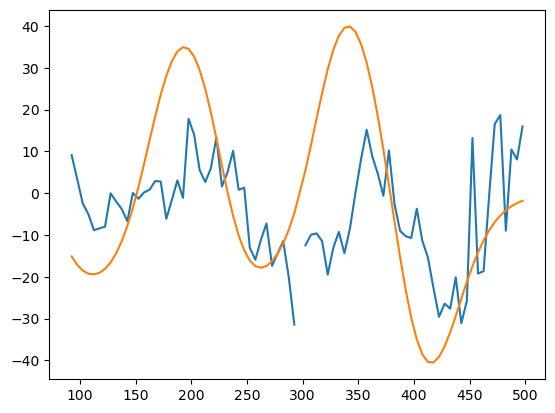

In [ ]:
sed_data = pd.read_csv(
    f"../../paleomag_mcmc/dat/prepared_data/VIC.csv"
)
preped = pd.read_csv(f"../results/preprocessed_data/VIC_mean.csv")
plt.plot(sed_data.depth, sed_data.D - sed_data.D.mean())
plt.plot(preped.depth, -preped.D)
# plt.plot(preped.depth, preped.D)
# sed_data

C087


/tmp/ipykernel_52481/4271510942.py:106: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


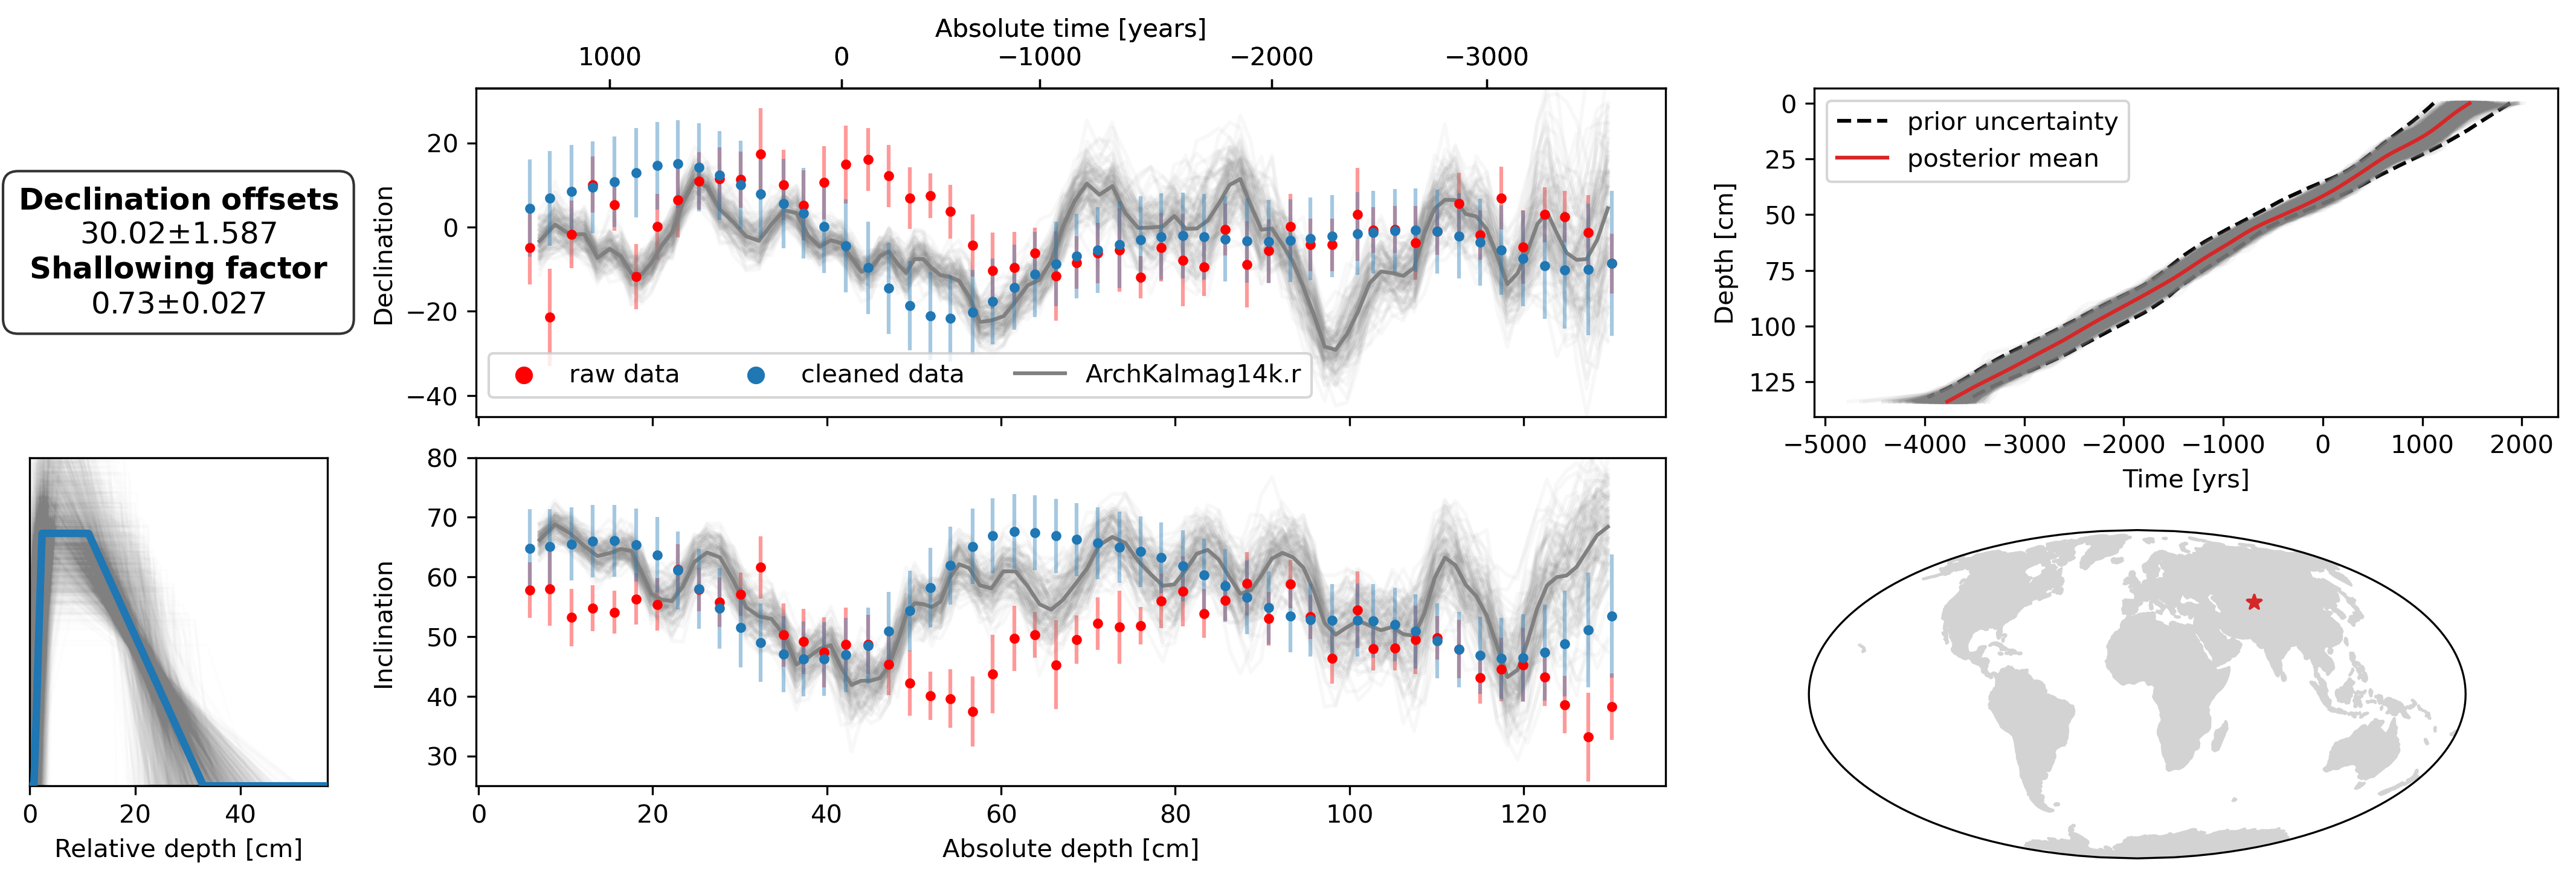

In [ ]:
plot_preped = True
plot_pred_on_data = False
core_ids = [
    # '305A5',
    # "Be7",
    # "BIW95-4",
    # "BOB24",
    # "BOB88",
    "C087",
    # "C142a",
    # "CHU",
    # "GGC25",
    # "HML",
    # 'NuurSKN',
    # 'NWA',
    # 'SWERUS-2-PC1',
    # 'U1305',
    # 'V95-7',
    # 'lm12-13-14-15'
]
props = dict(boxstyle="round,pad=0.5", facecolor="none", alpha=0.8)
DI = (
    2 * [["text"] + 3 * ["D"] + 2 * ["ADM"]]
    + 2 * [["text"] + 3 * ["D"] + 2 * ["ADM"]]
    + 2 * [["LIF"] + 3 * ["I"] + 2 * ["MAP"]]
    + 2 * [["LIF"] + 3 * ["I"] + 2 * ["MAP"]]
)

for core_id in core_ids:
    print(core_id)
    iData = az.from_netcdf(f"../results/{core_id}_result.nc")
    posterior = iData.posterior

    arch_data = pd.read_csv("../dat/real_arch_data.csv")
    # sed_data = pd.read_csv(f"../dat/sed_data/{core_id}_prepared.csv")
    # adm_data = pd.read_csv(f"../dat/sed_data/{core_id}_adm_data.csv")
    sed_data = pd.read_csv(
        f"../../paleomag_mcmc/dat/prepared_data/{core_id}.csv"
    )
    adm_data = pd.read_csv(
        f"../../paleomag_mcmc/dat/prepared_adm_data/{core_id}_adm_data.csv"
    )
    adm_data.rename(
        columns={"depth [cm]": "depth", "t [age BP]": "t", "dt [yrs.]": "dt"},
        inplace=True,
    )
    adm_data["t"] = 1950 - adm_data["t"]
    sed_data["F"] = np.nan
    sed_data["dF"] = np.nan
    arch = Data(arch_data)
    sed = Data(sed_data, adm_data)

    with pm.Model() as _:
        adm = AgeDepthModel(core_id, sed)

    thin = 1
    a_samps = posterior[f"a_{core_id}"].values[:, ::thin].reshape(-1, adm.D).T
    sum_a_samps = np.cumsum(a_samps, axis=0)
    theta_samps = posterior[f"theta_{core_id}"].values[:, ::thin].flatten()
    z = np.linspace(0, adm.D * adm.dd - 0.1, 1001)
    ind = (z // adm.dd).astype(int)
    t_samps = (
        theta_samps
        + sum_a_samps[ind] * adm.dd
        + a_samps[ind] * (z - adm.dd * (ind + 1))[:, None]
    )
    d2t_mean = interp1d(
        z, 1950 - t_samps.mean(axis=1), kind="linear", fill_value="extrapolate"
    )
    d2t_std = interp1d(
        z, 1950 - t_samps.std(axis=1), kind="linear", fill_value="extrapolate"
    )
    sed_data["t"] = d2t_mean(sed_data["depth"])
    sed_data["dt"] = d2t_std(sed_data["depth"])

    a_s = posterior[f"lock_in_{core_id}"].values.reshape(-1, 4)
    bs = np.cumsum(a_s.T, axis=0)

    f_shallow_samps = posterior[f"f_shallow_{core_id}"].values
    f_shallow_mean = f_shallow_samps.mean()
    f_shallow_std = f_shallow_samps.std()
    offset_mean = {}
    offset_std = {}
    for name in sed.subcores:
        offset_samps = posterior[f"offset_{name}"].values
        offset_mean[name] = offset_samps.mean()
        offset_std[name] = offset_samps.std()

    dec_pred = posterior[f"d_s_{core_id}"].values.reshape(-1, len(sed.idx_D))
    rI_sed = posterior[f"rI_sed_{core_id}"].values.reshape(-1, len(sed.idx_I))
    factor = np.sqrt(sed.errs_I + tDir**2)
    inc_pred = (rI_sed * factor + sed.out_I)

    lif_samps, lif_mean = get_lif_samps_and_mean(bs, lif_knots)

    fig, axs = plt.subplot_mosaic(
        DI, figsize=(18, 5), gridspec_kw=dict(hspace=0.8, wspace=0.5), dpi=300
    )
    fig.align_ylabels()
    axs["text"].axis("off")
    axs["D"].set_xticklabels([])

    sed_temp = sed_data.copy()
    sed_temp.D -= np.mean(sed_data.D)
    sed_temp.D = adjust_declination(sed_temp.D)
    axs["D"].scatter([], [], c=plt.get_cmap("autumn")(0), label="raw data")
    axs["D"].scatter([], [], c="C0", label="cleaned data")
    axs["D"].plot([], [], c="gray", label="ArchKalmag14k.r")
    axs["D"].legend(bbox_to_anchor=(0, 0.02), loc="lower left", ncol=3)
    plot_DIF(
        sed_temp,
        axs["D"],
        axs["I"],
        None,
        None,
        time_or_depth="depth",
        xerr=False,
        yerr=True,
        limit_y_to_data=True,
        legend=False,
        subs_cmap="autumn",
        model_file=akm_file,
    )
    if plot_pred_on_data:
        axs["D"].plot(sed.depth, dec_pred.T, c="C0", alpha=0.05, ls="", marker=".")
        axs["I"].plot(sed.depth, inc_pred.T, c="C0", alpha=0.05, ls="", marker=".")
    if plot_preped:
        preped_sed_all = pd.read_csv(f"../results/preprocessed_data/{core_id}_all.csv")
        preped_sed_mean = pd.read_csv(f"../results/preprocessed_data/{core_id}_mean.csv")
        for i, preped in enumerate([preped_sed_all]):
            preped["t"] = sed_data["t"]
            preped["dt"] = sed_data["dt"]
            plot_DIF(preped, axs["D"], axs["I"], None, None, time_or_depth="depth", xerr=False, yerr=True, legend=False, distinguish_subs=False, color=f"C{i}")
    offsets_text = r"$\bf{Declination\ offsets}$" + "\n"
    for i, name in enumerate(sed.subcores):
        offsets_text += (
            rf"{name}: {offset_mean[name]:.2f}$\pm${offset_std[name]:.3f}" if len(sed.subcores)>1 else rf"{offset_mean[name]:.2f}$\pm${offset_std[name]:.3f}"
        )
        offsets_text += "\n" if i + 1 < len(sed.subcores) else ""
    f_shallow_text = r"$\bf{Shallowing\ factor}$" + "\n"
    f_shallow_text += rf"{f_shallow_mean:.2f}$\pm${f_shallow_std:.3f}"
    axs["text"].text(
        0.5,
        0.5,
        offsets_text + "\n" + f_shallow_text,
        transform=axs["text"].transAxes,
        va="center",
        ha="center",
        bbox=props,
        fontsize=12,
    )
    axs["LIF"].plot(lif_knots, lif_mean, c="C0", lw=3, zorder=3)
    axs["LIF"].plot(lif_knots, lif_samps, c="gray", lw=1, zorder=1, alpha=0.01)
    axs["LIF"].set_ylim(0, 1.3 * max(lif_mean))
    axs["LIF"].set_xlim(0, 1.1 * lif_knots[max(np.nonzero(lif_samps)[0])])
    axs["LIF"].set_yticks([], [])
    axs["LIF"].set_xlabel("Relative depth [cm]")

    for i, age_lim in enumerate(
        [adm_data.t + adm_data.dt, adm_data.t - adm_data.dt]
    ):
        axs["ADM"].plot(
            age_lim,
            sed.adm_data["depth"],
            color="black",
            ls="--",
            label="prior uncertainty" if i == 0 else None,
        )
    axs["ADM"].plot(1950 - t_samps, z, zorder=2, color="grey", alpha=0.05)
    axs["ADM"].plot(
        1950 - t_samps.mean(axis=1),
        z,
        zorder=3,
        color="C3",
        label="posterior mean",
    )
    axs["ADM"].set_xlabel("Time [yrs]")
    axs["ADM"].set_ylabel("Depth [cm]")
    axs["ADM"].invert_yaxis()
    axs["ADM"].legend()

    plot_map(sed_data.lat[0], sed_data.lon[0], fig, axs["MAP"])

    # axs["D"].set_title(f"Results for {core_id}", fontsize=16)
    
    if len(limits[core_id]) > 0:
        axs["D"].set_ylim((-45, 33))
        axs["I"].set_ylim((25, 80))

    # plt.savefig(f'../result_plots/{core_id}.png', bbox_inches="tight")
    # plt.close()
    plt.show()

/tmp/ipykernel_4422/2593059892.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


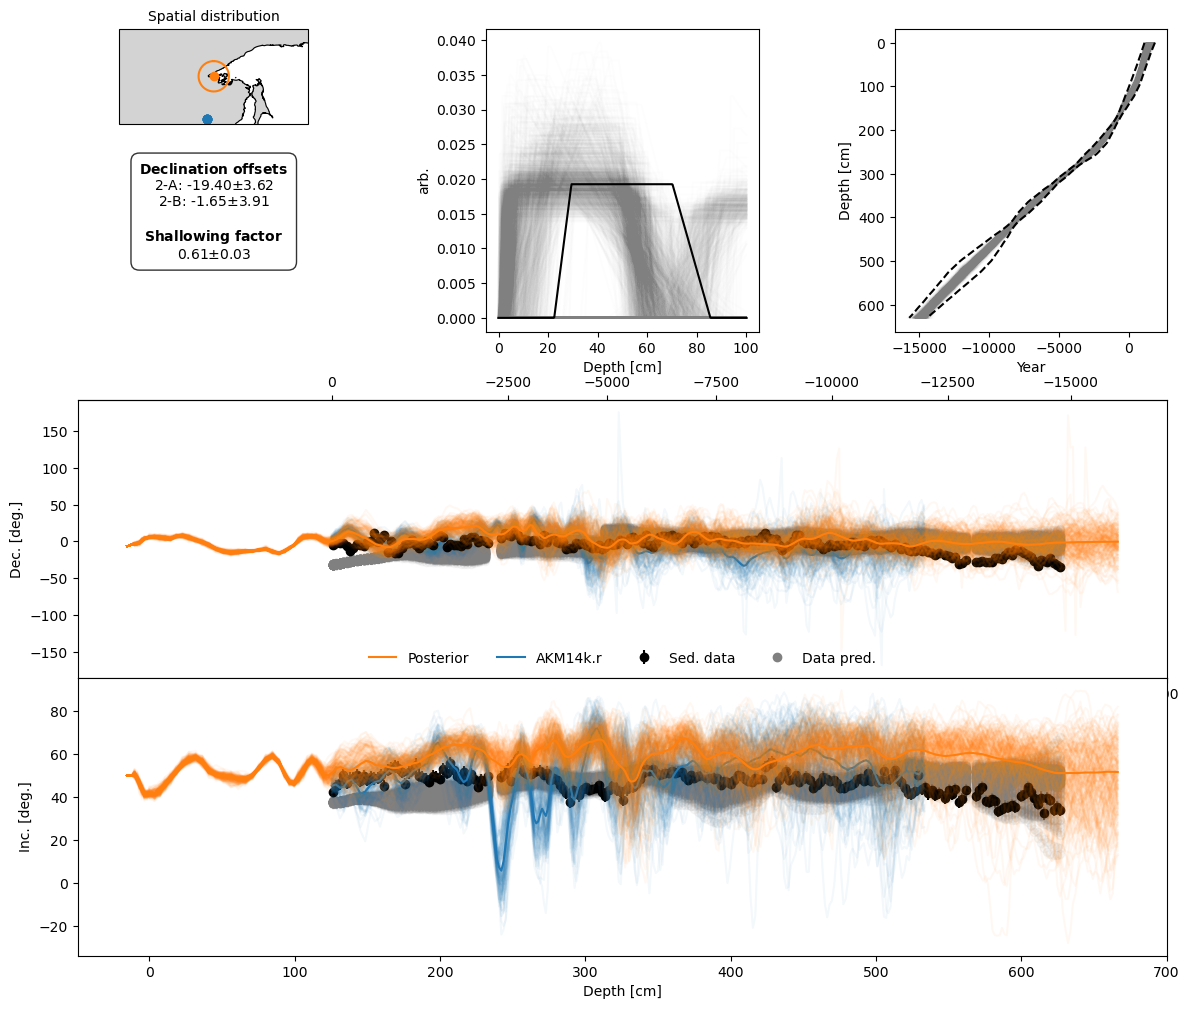

In [9]:
# from matplotlib import pyplot as plt, gridspec
# from matplotlib.lines import Line2D
# from cartopy import crs as ccrs, feature as cfeature
# from scipy.interpolate import BSpline
# from utils import interp_adm_np

# t_min = round(min(arch_data['t']) / 1000) * 1000
# t_max = round(max(arch_data['t']) / 1000) * 1000
# n_bins = int((t_max - t_min) / 100) * 2 + 1
# bins = np.linspace(t_min, t_max, n_bins)
# knots = np.arange(min(min(sed_data.t), -6000) - 1000, 2000 + 50, 50)

# def gcd(p1, p2):
#     hav = np.sin((p2[0] - p1[0])/2)**2 \
#         + np.cos(p1[0])*np.cos(p2[0])*np.sin((p2[1] - p1[1])/2)**2
#     return 2 * REARTH * np.arcsin(np.sqrt(hav))


# def reloc_f(f, loc, reloc):
#     colat = np.deg2rad(90-loc[0])
#     recolat = np.deg2rad(90-reloc[0])
#     res = f * np.sqrt(
#         np.abs((1 + 3*np.cos(recolat)**2) / (1 + 3*np.cos(colat)**2))
#     )
#     return res


# def reloc_i(i, loc, reloc):
#     i_dip = np.arctan(2*np.tan(loc[0]))
#     anom = i - i_dip
#     return anom + np.arctan(2*np.tan(reloc[0]))

# fig = plt.figure(figsize=(12, 10))
# proj = ccrs.Mollweide()

# gs1 = gridspec.GridSpec(5, 3)
# gs1.update(hspace=1.2, wspace=0.5)

# map_ax = plt.subplot(gs1[0, 0], projection=ccrs.PlateCarree())
# lock_ax = plt.subplot(gs1[0:2, 1])
# adm_ax = plt.subplot(gs1[0:2, 2])

# axs = np.empty(2, dtype="object")
# gs2 = gridspec.GridSpec(10, 1)
# gs2.update(hspace=0, wspace=0)
# axs[0] = plt.subplot(gs2[4:7, :])
# axs[1] = plt.subplot(gs2[7:, :])

# axs[1].sharex(axs[0])

# # c_ages = iData.posterior[f"c_ages_{ID}"].values.reshape(
# #     -1,
# #     sed.modelled_depths.shape[0],
# # )
# # alpha_0 = iData.posterior[f"alphas_level_1_{ID}"].values
# alpha_0 = alpha_0.flatten().mean()

# t_i = 1950 - c_ages.mean(axis=0)
# d_i = sed.modelled_depths

# spl_t_knots = np.concatenate(([-t_i[0]], -t_i, [-t_i[-1]]))
# _t2dspl = BSpline(spl_t_knots, d_i, 1)

# err_t2d = _t2dspl.derivative()(_t2dspl.t[1:-1]).max()


# def t2d(x):
#     return _t2dspl(-x)


# spl_d_knots = np.concatenate(([d_i[0]], d_i, [d_i[-1]]))
# d2t = BSpline(spl_d_knots, t_i, 1)

# knots_d = interp_adm_np(-knots, -t_i, sed.modelled_depths, alpha_0)
# # a_s = np.array(iData.posterior[f"lock_in_{ID}"]).reshape(-1, 4)
# # a_s = a_s.mean(axis=0)
# d_io = sed.depth[None, :] - knots_d[:, None]

# bs = np.cumsum(a_s.mean(axis=0), axis=0)
# beta = 2 / (bs[3] + bs[2] - bs[1] - bs[0])
# # F_01 = 0.
# F_12 = beta * (d_io - bs[0]) ** 2 / 2 / (bs[1] - bs[0])
# F_23 = beta * (d_io - (bs[1] + bs[0]) / 2)
# F_34 = beta * (
#     -(d_io**2 / 2 - bs[3] * d_io + bs[2] ** 2 / 2) / (bs[3] - bs[2])
#     - (bs[1] + bs[0]) / 2
# )
# F_4x = 1

# # ind_01 = d_io <= bs[0]
# ind_12 = (bs[0] < d_io) * (d_io <= bs[1])
# ind_23 = (bs[1] < d_io) * (d_io <= bs[2])
# ind_34 = (bs[2] < d_io) * (d_io <= bs[3])
# ind_4x = bs[3] < d_io

# ints = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34 + ind_4x * F_4x

# weights = ints[1:] - ints[:-1]
# # Normalize, i.e. increase the weight of the present day field for
# # sediments that see "the future" due to incomplete lockin
# # XXX there might be a more efficient way to do this
# today_component = np.zeros(len(knots) - 1)
# today_component[-1] = 1
# weights += (1 - weights.sum(axis=0))[None, :] * today_component[:, None]

# coeffs_s = np.einsum("ijk, jl->ilk", coeffs[:, :-1, :], weights)
# nez_s = np.einsum("ij, i...->j...", sed.base, coeffs_s.transpose(2, 1, 0))
# d_s, i_s, f_s = nez2dif(*nez_s)
# d_s = d_s[sed.idx_D]
# i_s = i_s[sed.idx_I]

# nez = np.einsum("ij, i...->j...", sed.base, coeffs.transpose(2, 1, 0))
# d, i, f = nez2dif(*nez)
# # decl_corr = np.zeros_like(sed_data.D)
# # for name in sed.subcores:
# #     decl_corr += (
# #         sed.subcores[name][0]
# #         * np.mean(iData.posterior[f"offset_{name}"]).item()
# #     )

# # f_shallow = np.mean(iData.posterior[f"f_shallow_{ID}"]).item()

# # from plot_functions import plot_DIF

# # plot_DIF(sed_data, axD=axs[0], axI=axs[1], time_or_depth="depth", model_file=akm_file)

# # cmap = plt.get_cmap("winter")
# # norm = plt.Normalize(vmin=0, vmax=len(sed_data["subs"].unique()))
# # for idx, (sub_id, sub) in enumerate(sed_data.groupby("subs")):
# axs[0].errorbar(
#     sed.depth,
#     sed_data.D,
#     yerr=sed_data.dD,
#     ls="",
#     color="black",
#     marker="o",
#     zorder=1,
#     label="Sed. data",
# )

# axs[1].errorbar(
#     sed.depth,
#     sed_data.I,
#     yerr=sed_data.dI,
#     ls="",
#     color="black",
#     marker="o",
#     zorder=0,
# )
# for _d_s in d_s[:, ::10].T:
#     axs[0].scatter(
#         sed.depth[sed.idx_D],
#         _d_s + decl_corr[sed.idx_D],
#         color="grey",
#         alpha=0.05,
#         zorder=0,
#     )
# axs[0].plot(knots_d, d[:, ::10], color="C1", alpha=0.05)
# axs[0].plot(knots_d, np.mean(d, axis=1), color="C1", label="Posterior")

# for _i_s in i_s[:, ::10].T:
#     axs[1].scatter(
#         sed.depth,
#         np.rad2deg(np.arctan(np.tan(np.deg2rad(_i_s)) * f_shallow)),
#         color="grey",
#         alpha=0.05,
#         zorder=0,
#     )
# axs[1].plot(knots_d, i[:, ::10], color="C1", alpha=0.05)
# axs[1].plot(knots_d, np.mean(i, axis=1), color="C1")

# # plot ArchKalmag14k.r
# model_knots = akm_file["knots"]
# indices = np.where(
#     (model_knots >= min(sed_data.t)) & (model_knots <= max(sed_data.t))
# )[0]
# model_knots = model_knots[indices]
# model_coeffs = akm_file["samples"]
# model_coeffs = model_coeffs.transpose(1, 0, 2)[: model_coeffs.shape[1] // 2]
# model_coeffs = model_coeffs[:, :, indices]
# loc = np.array((90 - sed_data.lat[0], sed_data.lon[0], REARTH))
# base = dsh_basis(i2lm_l(model_coeffs.shape[0] - 1), loc[:, None])
# nez = np.einsum("ij, ikl->jkl", base, model_coeffs)
# d, i, f = nez2dif(*nez)
# axs[0].plot(t2d(model_knots), d.T, color="C0", alpha=0.05, zorder=1.0)
# axs[0].plot(
#     t2d(model_knots), d.mean(axis=0), color="C0", label="AKM14k.r", zorder=1.0
# )
# axs[1].plot(t2d(model_knots), i.T, color="C0", alpha=0.05, zorder=1.0)
# axs[1].plot(t2d(model_knots), i.mean(axis=0), color="C0", zorder=1.0)

# axs[0].set_ylabel("Dec. [deg.]")
# # axs[0].set_ylim(-60, 60)
# # axs[0].set_yticks([-75, -50, -25, 0, 25, 50, 75, ])
# axs[1].set_ylabel("Inc. [deg.]")
# # axs[1].set_ylim(45, 90)
# # axs[1].set_yticks([45, 55, 65, 75, 85, ])
# # axs[0].invert_xaxis()
# # axs[0].set_xlim(t2d(-4000), t2d(2000))
# axs[1].set_xlabel("Depth [cm]")

# ax_d2 = axs[0].secondary_xaxis("top", functions=(d2t, t2d))
# ax_d2.set_label("Time [yrs.]")

# fig.tight_layout()

# degs = 7

# map_ax.cla()
# map_ax.projection.central_longitude = loc[1]

# # map_ax.projection.latitude_true_scale = loc[0]

# local_proj = map_ax.projection
# lonlim = np.array([loc[1] - 2 * degs, loc[1] + 2 * degs])
# if lonlim[0] < -180:
#     lonlim[0] = -180
# if lonlim[1] >= 180:
#     lonlim[1] = 180
# xlims, ylims, _ = local_proj.transform_points(
#     ccrs.Geodetic(), lonlim, np.array([loc[0] - degs, loc[0] + degs])
# ).T

# arr = np.linspace(0.0, 2 * np.pi, 201)
# R = 250
# r = R / 6371.2 * 180 / np.pi
# circ = r * np.array([np.cos(arr), np.sin(arr)])

# map_ax.set_xlim(xlims)
# map_ax.set_ylim(ylims)
# map_ax.set_title("Spatial distribution", fontsize=10)

# x, y, _ = local_proj.transform_points(
#     ccrs.Geodetic(), arch_data["lon"].to_numpy(), arch_data["lat"].to_numpy()
# ).T

# map_ax.scatter(x, y, color="C0", zorder=1, rasterized=True)

# map_ax.add_feature(cfeature.LAND, zorder=0, color="lightgray", rasterized=True)
# map_ax.coastlines(zorder=2, linewidth=0.8, rasterized=True)

# map_ax.scatter(
#     loc[1],
#     loc[0],
#     transform=ccrs.PlateCarree(),
#     c="C1",
#     zorder=3,
#     rasterized=True,
# )
# map_ax.plot(
#     circ[1] + loc[1],
#     circ[0] + loc[0],
#     color="C1",
#     linewidth=1.5,
#     zorder=3,
#     transform=ccrs.PlateCarree(),
#     rasterized=True,
# )


# # decl_str = []
# # for name in sed.subcores:
# #     decl_str.append(
# #         f"{name}: {iData.posterior[f'offset_{name}'].mean():.2f}"
# #         + rf"$\pm${iData.posterior[f'offset_{name}'].std():.2f}"
# #     )
# # decl_str = "\n".join(decl_str)

# f_shallow_str = rf"{iData.posterior[f'f_shallow_{ID}'].mean():.2f}$\pm${iData.posterior[f'f_shallow_{ID}'].std():.2f}"

# map_ax.text(
#     0.5,
#     -0.4,
#     r"$\bf{Declination\ offsets}$"
#     + "\n"
#     + decl_str
#     + "\n\n"
#     + r"$\bf{Shallowing\ factor}$"
#     + "\n"
#     + f_shallow_str,
#     transform=map_ax.transAxes,
#     va="top",
#     ha="center",
#     bbox=dict(boxstyle="round, pad=0.6", facecolor="none", alpha=0.8),
# )


# local_data = arch_data.query(
#     f"{loc[0]-degs} <= lat <= {loc[0]+degs} & "
#     f"{loc[1]-2*degs} <= lon <= {loc[1]+2*degs}"
# )

# gcds = gcd(
#     np.deg2rad(loc),
#     [np.deg2rad(arch_data["lat"]), np.deg2rad(arch_data["lon"])],
# )
# to_plt_dat = arch_data[gcds < R]
# idx_D = to_plt_dat.query("D==D").index
# dat_D = to_plt_dat["D"][idx_D].to_numpy()
# dat_dD = to_plt_dat["dD"][idx_D].to_numpy()
# if 0 < len(dat_D):
#     dat_D += -360 * (dat_D > 180) + 360 * (-180 > dat_D)
#     axs[0].errorbar(
#         t2d(to_plt_dat["t"][idx_D]),
#         dat_D,
#         xerr=to_plt_dat["dt"][idx_D] * err_t2d,
#         yerr=dat_dD,
#         color="C0",
#         ls="",
#         marker="s",
#         zorder=0,
#         rasterized=True,
#         label="Arch. data",
#     )
# idx_I = to_plt_dat.query("I==I").index
# dat_I = to_plt_dat["I"][idx_I].to_numpy()
# dat_dI = to_plt_dat["dI"][idx_I].to_numpy()
# if 0 < len(dat_I):
#     reloc_I = reloc_i(
#         dat_I,
#         to_plt_dat.loc[idx_I, ["lat", "lon"]].to_numpy().T,
#         loc,
#     )
#     axs[1].errorbar(
#         t2d(to_plt_dat["t"][idx_I]),
#         reloc_I,
#         xerr=to_plt_dat["dt"][idx_I] * err_t2d,
#         yerr=dat_dI,
#         color="C0",
#         ls="",
#         marker="s",
#         zorder=0,
#         rasterized=True,
#     )


# # a_s = np.array(iData.posterior[f"lock_in_{ID}"]).reshape(-1, 4).T

# bs = np.cumsum(a_s.T, axis=0)
# bs_mean = np.mean(bs, axis=1)

# depth = np.linspace(0, 100, 401)

# beta = 2 / (bs[3] + bs[2] - bs[1] - bs[0])
# F_01 = 0.0
# F_12 = (
#     beta[None, :]
#     * (depth[:, None] - bs[0, None, :])
#     / (bs[1] - bs[0])[None, :]
# )
# F_23 = beta[None, :]
# F_34 = (
#     beta[None, :]
#     * (bs[3, None, :] - depth[:, None])
#     / (bs[3] - bs[2])[None, :]
# )
# F_4x = 0.0

# ind_12 = (bs[0, None, :] < depth[:, None]) * (depth[:, None] <= bs[1, None, :])
# ind_23 = (bs[1, None, :] < depth[:, None]) * (depth[:, None] <= bs[2, None, :])
# ind_34 = (bs[2, None, :] < depth[:, None]) * (depth[:, None] <= bs[3, None, :])

# lis = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34

# beta = 2 / (bs_mean[3] + bs_mean[2] - bs_mean[1] - bs_mean[0])
# F_01 = 0.0
# F_12 = beta * (depth - bs_mean[0]) / (bs_mean[1] - bs_mean[0])
# F_23 = beta
# F_34 = beta * (bs_mean[3] - depth) / (bs_mean[3] - bs_mean[2])
# F_4x = 0.0

# ind_12 = (bs_mean[0] < depth) * (depth <= bs_mean[1])
# ind_23 = (bs_mean[1] < depth) * (depth <= bs_mean[2])
# ind_34 = (bs_mean[2] < depth) * (depth <= bs_mean[3])

# li_mean = ind_12 * F_12 + ind_23 * F_23 + ind_34 * F_34

# lock_ax.plot(
#     depth,
#     lis,
#     alpha=0.01,
#     color="grey",
# )
# lock_ax.plot(
#     depth,
#     li_mean,
#     alpha=1,
#     color="black",
# )

# lock_ax.set_xlabel("Depth [cm]")
# lock_ax.set_ylabel("arb.")
# # lock_ax.set_ylim(None, 0.06)

# adm_ax.plot(
#     (1950 - c_ages.T), sed.modelled_depths, zorder=0, color="grey", alpha=0.005
# )

# adm_ax.plot(
#     (1950 - sed.adm_t) + sed.adm_dt, sed.adm_depth, color="black", ls="--"
# )
# adm_ax.plot(
#     (1950 - sed.adm_t) - sed.adm_dt, sed.adm_depth, color="black", ls="--"
# )

# adm_ax.set_xlabel("Year")
# adm_ax.set_ylabel("Depth [cm]")
# adm_ax.invert_yaxis()

# handles, labels = axs[0].get_legend_handles_labels()
# point = Line2D(
#     [0], [0], label="Data pred.", marker="o", color="grey", linestyle=""
# )

# handles.extend([point])
# axs[0].legend(handles=handles, loc="lower center", ncols=5, frameon=False)

# # fig.savefig(f"../fig/pred_{ID}.pdf", bbox_inches="tight", pad_inches=0.1)

# # fig.savefig(
# #     f"../fig/pred_{ID}.png",
# #     bbox_inches="tight",
# #     pad_inches=0.1
# #     dpi=200,
# # )